# Analysis of survey responses

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Plot settings for retina
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load data
fname = 'survey_results_processed.csv'
df = pd.read_csv(fname)

In [3]:
# Plot distribution of survey answers by respondents
def question_boxplots(_df: pd.DataFrame, title: str, fname: str = None):
    df_copy = _df.copy()
    df_copy['res'] = _df['res'].map({
        "Strongly agree": -2,
        "Somewhat agree": -1,
        "Neither agree nor disagree": 0,
        "Somewhat disagree": 1,
        "Strongly disagree": 2,
    })
    plt.rcParams["figure.figsize"] = [16,10]
    g = sns.boxenplot(x='qid', y='res', data=df_copy)
    sns.swarmplot(x='qid', y='res', data=df_copy, color='k')
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    g.set_title(title, size='xx-large')
    if (fname):
        plt.savefig(f'figures/{fname}', bbox_inches='tight')
    plt.show()

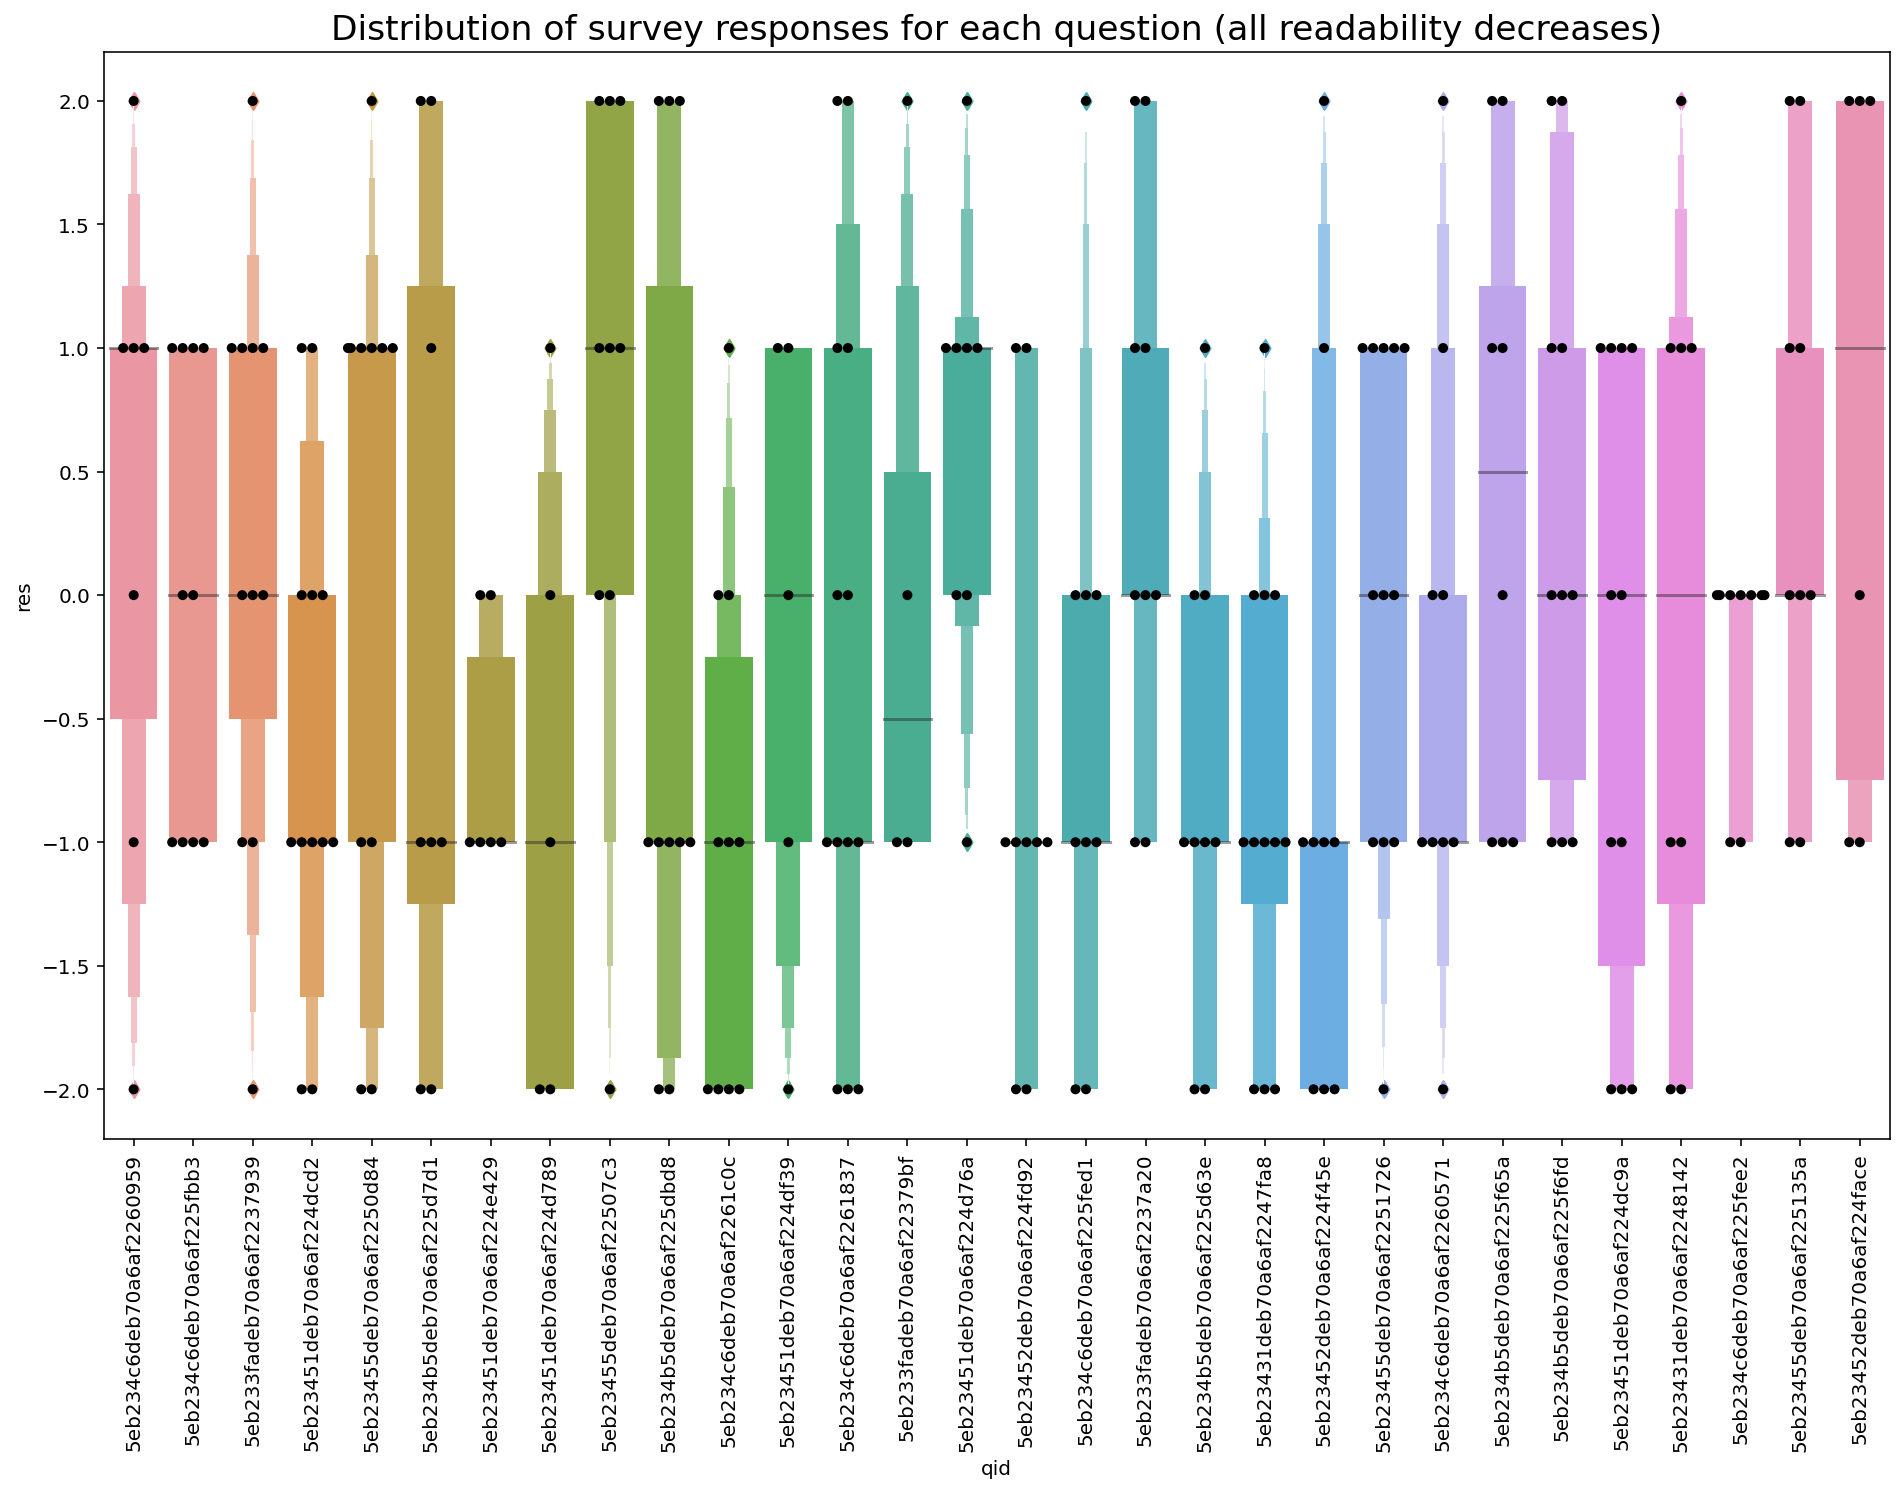

In [4]:
question_boxplots(df, "Distribution of survey responses for each question (all readability decreases)", 'boxplots.png')

Each boxplot represents the responses given for a specific pair of paragraphs.  
The data we loaded presents all rows as readability decreases (the delta in Flesch—Kincaid grade is always positive), so the expected response is agreement (-2 or -1 on the boxplot).

What we would like to see is a majority of responses in the negative part (-2, -1).  
Before checking the results further, we filter away all questions that had less than 10 respondents.

In [5]:
# Extract questions with the most answers
def get_high_count_df(_df: pd.DataFrame) -> pd.DataFrame:
    counts_q_df = _df.groupby('qid').count()['res']
    high_count_qids = counts_q_df[counts_q_df > 9].index
    high_count_df = _df[_df['qid'].isin(high_count_qids)]
    return high_count_df
high_count_df = get_high_count_df(df)

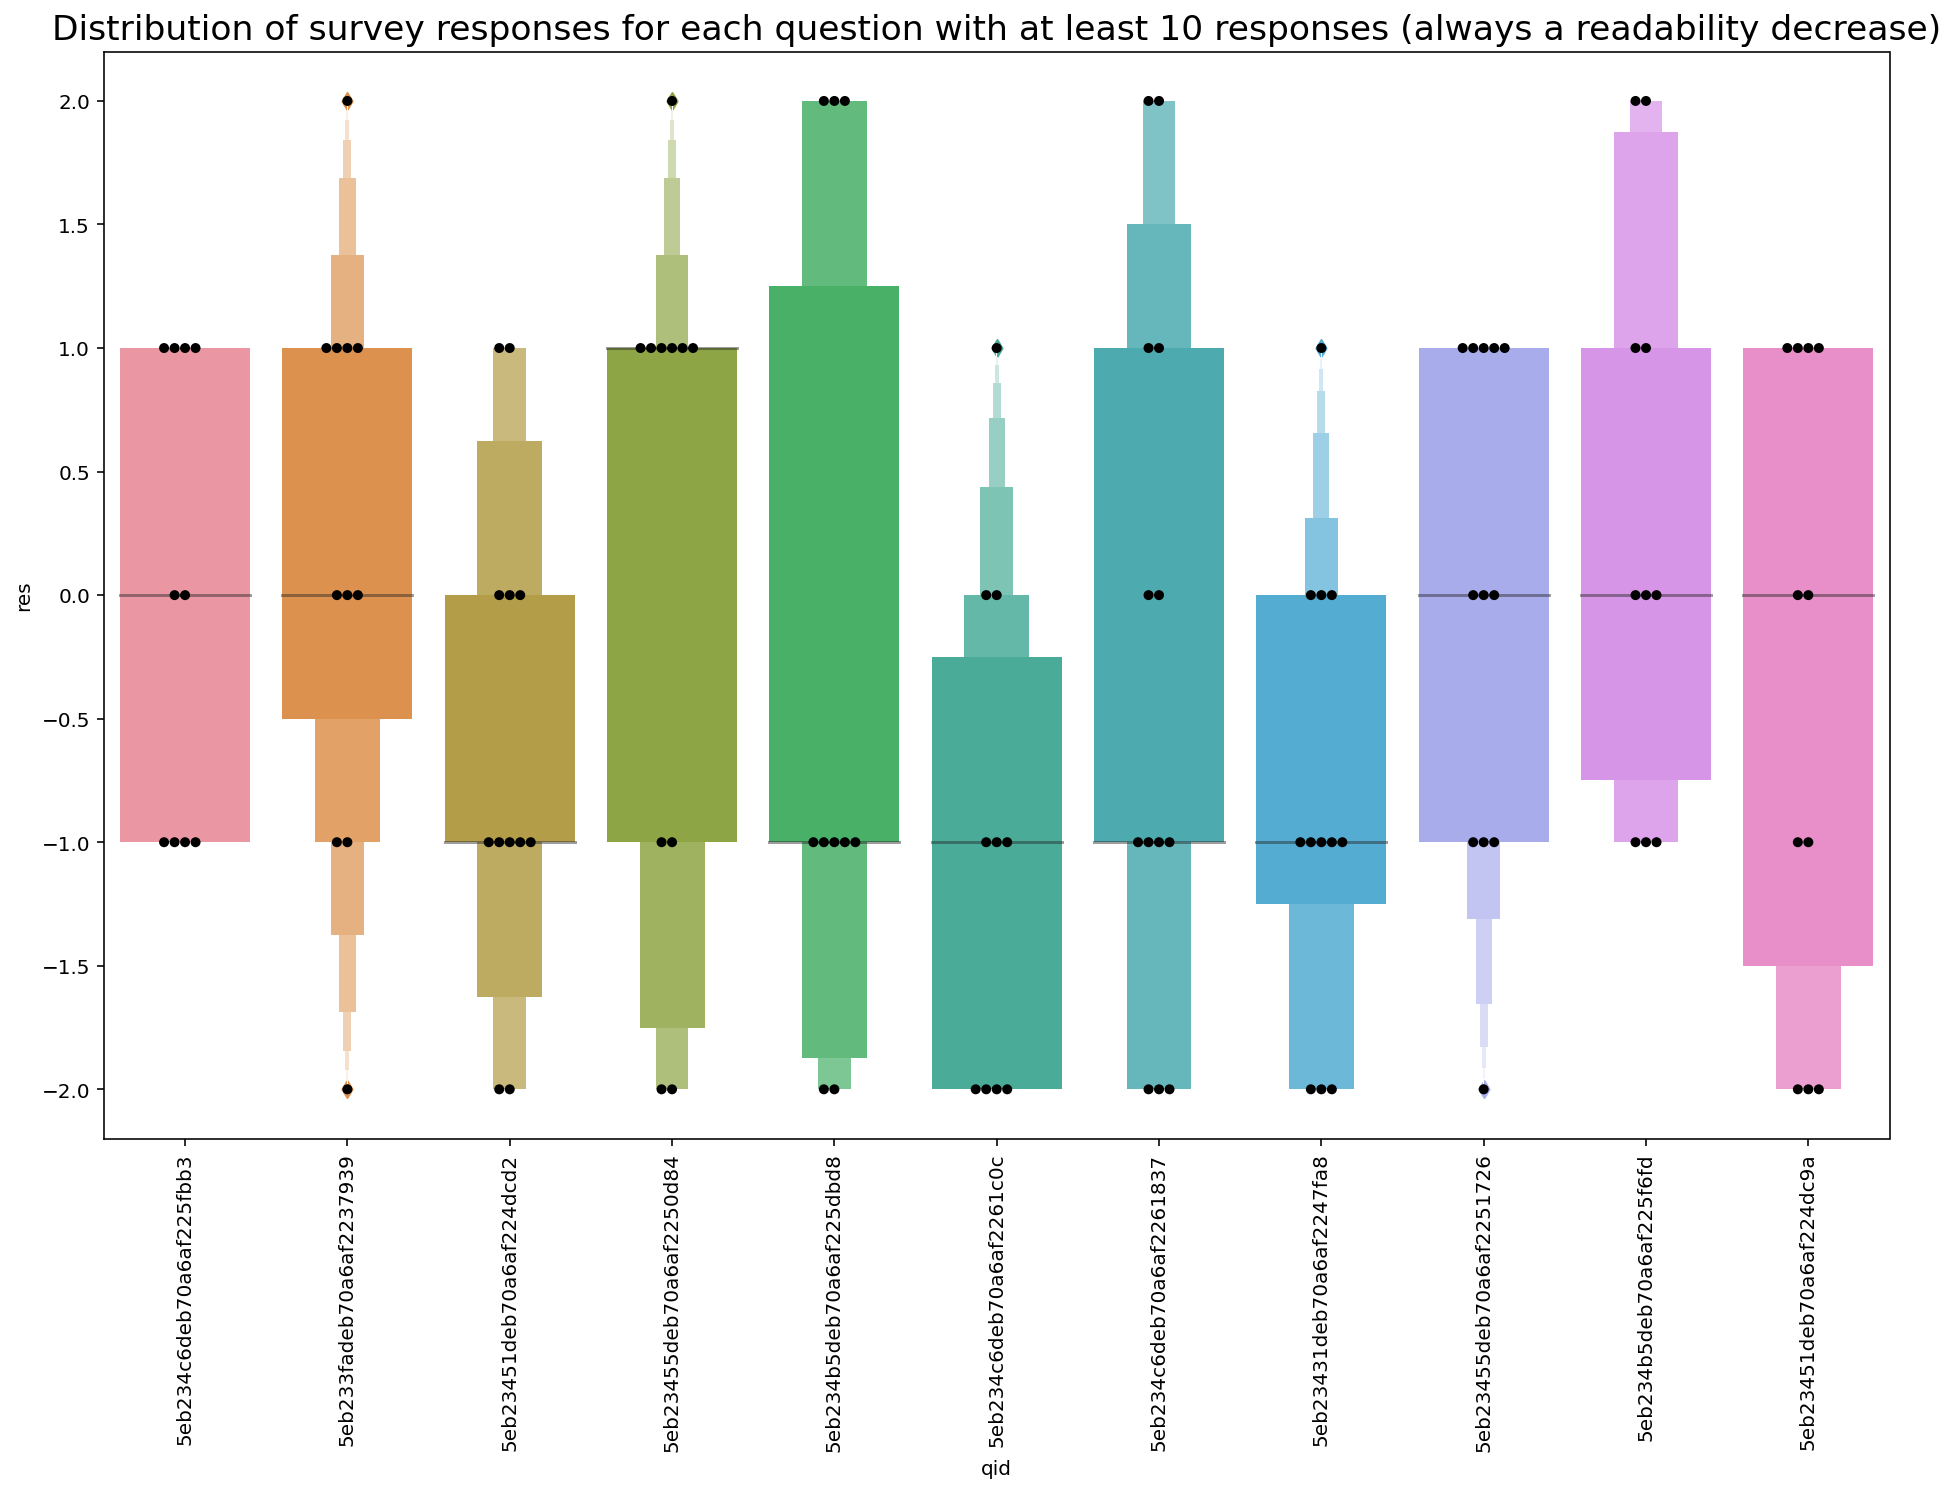

In [7]:
question_boxplots(high_count_df, "Distribution of survey responses for each question with at least 10 responses (always a readability decrease)", 'boxplots_10.png')

In these last boxplots we see the level of agreement for all questions with 10 or more reponses.  
When dealing with likert survey responses, however, a better visualization is achieved using stacked diverging bar charts.

In [8]:
def plot_likert(_df: pd.DataFrame, fname: str = None):
    # Copy df because code below mutates df
    copy_df = _df.copy().reindex(index=_df.index[::-1])
    # Plot a centered diverging bar chart with likert data
    # Inspiration from https://blog.orikami.nl/behind-the-screens-likert-scale-visualization-368557ad72d1
    plt.rcParams["figure.figsize"] = [16,10]
    likert_colors = ['white', 'firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']

    # Insert invisible "white" column to align middle of "Neither agree nor disagree" of all charts
    middles = copy_df[['Strongly disagree', 'Somewhat disagree']]\
        .sum(axis=1) + copy_df['Neither agree nor disagree']*.5
    longest = middles.max()*1.1
    copy_df.insert(0, '', (middles - longest).abs())

    # Plot stacked bar chart
    ax = copy_df.plot.barh(
        stacked=True, 
        color=likert_colors, 
        edgecolor='none'
    )

    # Plot a vertical dashed line at 0
    z = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
    z.set_zorder(-1)

    # Create custom tick positions and labels
    xvalues = [longest-9+i for i in range(19)]
    xlabels = ['{:4.0f}'.format(x-longest) for x in xvalues]
    plt.xticks(xvalues, xlabels)

    # Shrink current axis's height by 10% on the bottom to make room for the legend
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.8])

    # Create the legend below the chart
    handler, label = ax.get_legend_handles_labels()
    ax.legend(
        handler, 
        label, 
        loc='upper center', 
        bbox_to_anchor=(.5, -0.1), 
        ncol=5, 
        edgecolor='white'
    )

    # Set labels and title
    plt.xlabel('Count')
    plt.ylabel('')
    plt.title("Counts of survey responses for each measured readability increase")
    if (fname):
        plt.savefig(f'figures/{fname}', bbox_inches='tight')
    plt.show()

In [ ]:
# Create response counts dataframe, and rename columns to likert strings (inverted, since we inverted the questions)
likert_counts = pd\
    .crosstab(high_count_df['qid'], high_count_df['res'])\
    [["Strongly disagree", "Somewhat disagree", "Neither agree nor disagree", "Somewhat agree", "Strongly agree"]]

In [ ]:
likert_counts

In [ ]:
plot_likert(likert_counts, 'likert_counts.png')

This visualization is more informative than the previous ones.  
The blue bars represent all responses where the respondent agreed that the readability decreased from the first to the second paragraph.  
The red bars, respectively, where the respondent disagreed, and thought instead that readability increased.  

It is easy to see in which cases the survey respondents really agreed with the real deltas (e.g. second, fourth, and last questions).  
It also shows that there were cases where respondents did not agree with the real deltas (first and fifth).  
If we remove neutral responses we could see more.

In [ ]:
likert_counts_no_neutral = likert_counts.copy()
likert_counts_no_neutral['Neither agree nor disagree'] = 0
plot_likert(likert_counts_no_neutral, 'likert_counts_no_neutral.png')

In this last visualization, what said above is even more apparent.  
In order to inspect the specific cases, we generate a document with all paragraph texts.

In [ ]:
# Write a textual report with compared paragraphs, real readability delta, and summary of survey responses.

def para_report(para: str, para_type: str, fre: float, fkg: float) -> str:
    return (f"**Paragraph {para_type}**  \n"
            f"{para}  \n\n"
            f"*Flesch reading ease*: {fre}  \n"
            f"*Flesch&mdash;Kincaid grade level*: {fkg}  \n\n")

def delta_str(d: float) -> str:
    return f'+{d}' if d > 0 else f'{d}'

def delta_inc_dec(delta: float) -> str:
    if delta < 0:
        return 'decreased'
    elif delta > 0:
        return 'increased'
    else:
        return 'did not change'

def res_inc_dec(res: int) -> str:
    if res == 'Strongly agree' or res == "Somewhat agree":
        return 'decreased'
    elif res == "Somewhat disagree" or res == "Strongly disagree":
        return 'increased'
    else:
        return 'did not change'

def write_report_on_candidates(_df: pd.DataFrame):
    report_fname = 'survey_questions_report.md'
    with open(report_fname, 'w+') as f:
        f.write('# Analysis of survey responses on all pairs of paragraphs\n\n')
        f.write('We consider only the pairs for which there were 10 or more responses.  \n')
        f.write('The survey respondents were asked how much they agreed with the following statement:  \n')
        f.write('> Paragraph A is more readable than paragraph B.\n\n')
        f.write(
            ('To simplify analysis of the results, each pair in the results dataset has been swapped (if needed) '
             'so that Paragraph A is indeed more readable than paragraph B, meaning that there has been '
             'a readability decrease between the two versions. Survey responses have of course been swapped '
             'too when necessary.\n\n'))
        f.write(
            ('This means that for all questions, we expect the respondents to agree with the statement '
             '(and thus select "Strongly agree" or "Somewhat agree").\n\n'))
        for qid, responses in _df.groupby('qid'):
            res = responses.iloc[0]
            para_a, fre_a, fkg_a = res['from.text'], res['from.FRE'], res['from.FKG']
            para_b, fre_b, fkg_b = res['to.text'], res['to.FRE'], res['to.FKG']
            f.write(f'## Paragraph pair {qid}\n')
            f.write(f'### Paragraphs\n')
            f.write(para_report(para_a, 'A', fre_a, fkg_a))
            f.write(para_report(para_b, 'B', fre_b, fkg_b))
            f.write(f'### Readability deltas\n')
            f.write('| Metric | Delta | Meaning |\n')
            f.write('| --- | ---: | --- |\n')
            f.write(f"| *Flesch reading ease* | {delta_str(res['freDelta'])} | readability {delta_inc_dec(res['freDelta'])} |\n")
            f.write(f"| *Flesch&mdash;Kincaid grade level* | {delta_str(res['fkglDelta'])} | readability {delta_inc_dec(- res['fkglDelta'])} |\n\n")
            f.write(f'### Survey responses\n')
            f.write('| Response | Meaning | Count |\n')
            f.write('| --- | ---: | --- |\n')
            for value, count in responses['res'].value_counts().sort_index().items():
                f.write(f"| {value} | readability {res_inc_dec(value)} | {count} |\n")
            f.write('\n')

write_report_on_candidates(high_count_df)